## Lane detection
### Program flow:
- Imports and preliminaries
- Helper functions
- Pipeline for lane detection in an static image
    - Convert to gray scale
    - Apply Gaussian blur
    - NOT USED: Color detection
    - Canny transformation
    - Region limits
    - Hough transformation for lane detection
    - Merge original image and lines
- Test pipeline in some static images
- Process video

### Imports and preliminaries

In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

### Helper functions

In [2]:
import math
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [3]:
def line_drawing_pipeline(original_image):
    '''
    Function receives an image and returns the same image with the detected lines superimposed in red
    input: image (np.array(height, withd, 3))
    output: image (np.array(height, withd, 3))
    '''
    # Convert to gray scale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    
    # Apply gaussian blur
    kernel_size = 3
    blurred_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)
    
    # Canny edge detection
    low_threshold = 75
    high_threshold = 200
    edges_image = cv2.Canny(blurred_image, low_threshold, high_threshold)
    
    # Define the region of interest:
    width = original_image.shape[1]
    height = original_image.shape[0]
    base_offset = 50
    apex_width = 80
    vertical_factor = 3/5
    vertices = np.array([[(base_offset,height-bottom_offset),
                          ((width-apex_width)/2,height*vertical_factor),
                          ((width+apex_width)/2,height*vertical_factor),
                          (width - base_offset, height-bottom_offset)]],dtype=np.int32)    
    
    # Detect lines in the region of interest through Hough transformation
    masked_image = region_of_interest(edges_image, vertices)
    
    ## Parameters for hough line detection
    rho_accuracy = 1
    theta_accuracy = np.pi/360
    min_line_len = 50

    # Parameters for line drawing
    color = (255,0,0)
    line_width = 10
    
    # Get hough lines (in raw form: np array of rho theta for each line)
    lines = cv2.HoughLines(masked_image,rho_accuracy,theta_accuracy,min_line_len)   
    
    # Divide lines left from rigth based on theta:
    left_lines = []
    right_lines = []
    for line in lines:
        rho,theta = line.flatten()
        if theta > np.pi * (3/4 - 1/10) and theta < np.pi * (3/4 + 1/10):
            left_lines.append((rho, theta))
        elif theta > np.pi * (1/4 - 1/10) and theta < np.pi * (1/4 + 1/10):
            right_lines.append((rho, theta))

    # Average rho theta to get master lines
    average_lines = []
    left_lines = np.array(left_lines)
    if len(left_lines) > 0:
        left_average = np.average(left_lines, axis=0)
        average_lines.append(left_average)
    if len(right_lines) > 0:
        right_average = np.average(right_lines, axis=0)
        average_lines.append(right_average)

    # Print master left and right lines
    lined_image = np.copy(original_image)*0
    for rho, theta in average_lines:    
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 2*width*(-b))
        y1 = int(y0 + 2*width*(a))
        x2 = int(x0 - 2*width*(-b))
        y2 = int(y0 - 2*width*(a))

        cv2.line(lined_image,(x1,y1),(x2,y2),color,line_width)  
    masked_lines = region_of_interest(lined_image, vertices)  
    
    # Return original image with the super-imposed lines
    α = 1
    β = 1
    λ = 0.
    return cv2.addWeighted(original_image, α, masked_lines, β, λ)

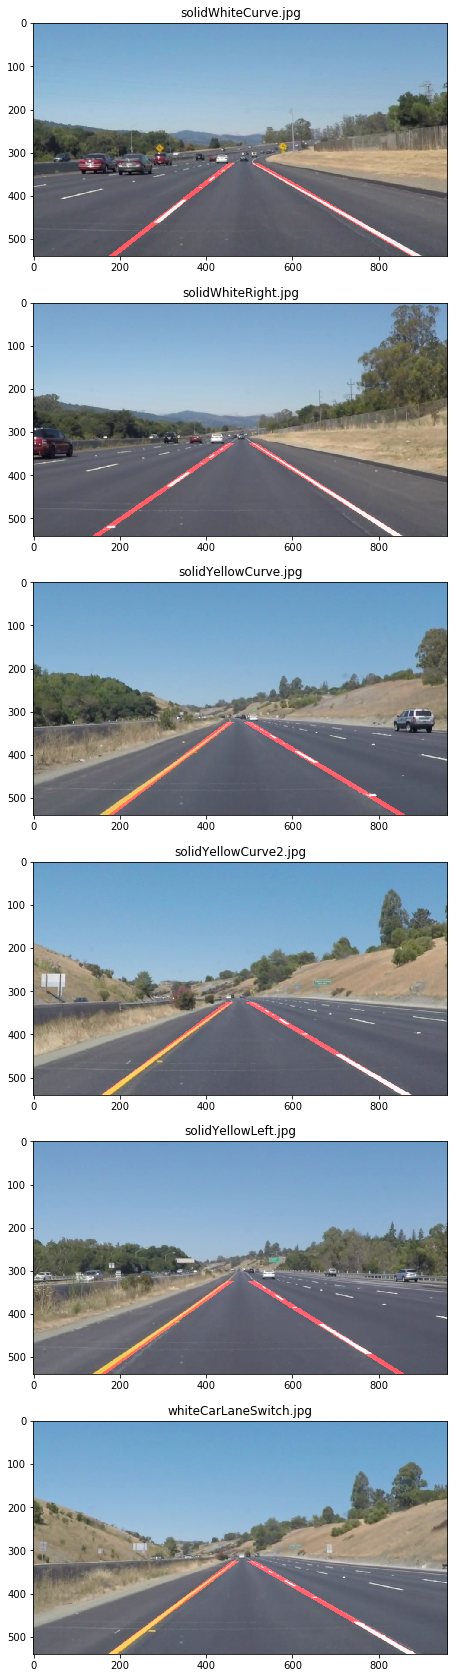

In [4]:
# Test pipeline:
bottom_offset = 0
input_path = 'test_images/'
output_path = 'test_images_output/'
test_images = ['solidWhiteCurve.jpg','solidWhiteRight.jpg',
               'solidYellowCurve.jpg', 'solidYellowCurve2.jpg',
               'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']

subplot_counter = 1
fig = plt.figure(figsize=(90, 30))
for file in test_images:
    image = mpimg.imread(input_path+file)
    a=fig.add_subplot(len(test_images),1,subplot_counter)
    subplot_counter += 1
    result_image = line_drawing_pipeline(image)
    cv2.imwrite(output_path+file, cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
    imgplot = plt.imshow(result_image)
    a.set_title(file)

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    return line_drawing_pipeline(image)

In [7]:
bottom_offset = 0
white_output = 'test_videos_output/solidWhiteRight.mp4'
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:21<00:00, 10.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.6 s, sys: 496 ms, total: 8.1 s
Wall time: 24.4 s


In [8]:
bottom_offset = 25
challenge_output = 'test_videos_output/challenge.mp4'
## clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,1)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:37<00:00,  5.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 15.3 s, sys: 2.45 s, total: 17.8 s
Wall time: 41.9 s
